<h1 align=center><font size = 5>The Battle of Neighborhoods - Dallas,Texas </font></h1>

## Introduction

A successful entrepreneur who owns multiple tutoring centers in North East US, is looking to expand in South. To start with, he wants to open a tutoring center in Dallas, Texas hence approached the Data Science team to help him locate the best neighborhood where he can establish a tutoring center and run it successfully.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#ref1">Download and Explore Dallas neighborhoods Dataset</a>

2. <a href="#ref2">Load Geographical coordinates of each neighborhood</a>

3. <a href="#ref3">Analyze each neighborhood in Dallas</a>  

4. <a href="#ref4">Cluster the neighborhoods in Dallas</a>
   
5. <a href="#ref5">Examine the clusters and Identify the best cluster to start a Tutoring Center in Dallas</a>  
    
6. <a href="#ref6">Conclusion</a>  

</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
#Install necessary modules
!pip install geopy
!pip install folium

In [2]:
#General libraries
import pandas as pd
import numpy as np
import re

# Libraries to scrape Wikipedia page
import urllib.request
from bs4 import BeautifulSoup

# Converts an address into latitude and longitude values
from geopy.geocoders import Nominatim

#Map rendering library
import folium

#Library to handle requests and JSON files
import requests
#from pandas.io.json import json_normalize
import json

# Matplotlib,Seaborn and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
print('Libraries imported.')

Libraries imported.


<a id="ref1"></a>
## 1. Download and Explore Dallas neighborhoods Dataset

For the Dallas neighborhood data, the city-data webpage has all the information needed to explore and cluster the neighborhoods. Data science team is tasked with extracting the data from the webpage and wrangle the data, clean it, and then read it into a pandas dataframe so that it can be used in Modeling.

Let's retrieve the webpage which has the required data.

In [3]:
dallas_url = 'http://www.city-data.com/nbmaps/neigh-Dallas-Texas.html'
dallas_page = urllib.request.urlopen(dallas_url)

Let's instantiate BeautifulSoup to find the 'neighborhood' section from the extracted page.

In [4]:
d_soup = BeautifulSoup(dallas_page,'lxml')
dallas_tables = d_soup.findAll('div',class_='neighborhood')

#### Read the data into a *dictornary*

In [5]:
name = []
population = []
male_avg_age = []
female_avg_age = []
median_houshold_income = []
city = []

dallas_cells=''
for div_table in dallas_tables:
    
    #Extract 'Neighborhood' name
    hood = div_table.find('strong')
    name.append(hood.find(text=True).strip())
    
    #Append 'City' name
    city.append('Dallas')
    
    #Extract 'Population count' for each Neighborhood.
    dallas_row = div_table.findAll(text=re.compile(r'\b\d+\b'))
    if len(dallas_row) > 1:
        population.append(float(dallas_row[1].replace(',','').strip()))
    else:
        population.append(np.nan)
        
    #Code to extract Age and Income for each Neighborhood    
    sub_table = div_table.findAll('div',class_='hgraph')
    if len(sub_table) > 0:
        #Extract Median Household Income for each Neighborhood
        income_row = sub_table[1].findAll('tr')
        income=float(income_row[0].findAll('td')[1].find(text=True).replace(',','').replace('$',''))
        if income > 0:
            median_houshold_income.append(income)
        
        #Extract Male and Female average age for each Neighborhood    
        age_row = sub_table[4].findAll('tr')
        male_age=age_row[0].findAll('td')
        female_age=age_row[1].findAll('td')
        try:
            male_avg_age.append(male_age[1].find(text=True).replace('years','').strip())
        except:
            male_avg_age.append(np.nan)
        try:
            female_avg_age.append(female_age[1].find(text=True).replace('years','').strip())
        except:
            female_avg_age.append(np.nan)
    else:
        median_houshold_income.append(np.nan)
        male_avg_age.append(np.nan)
        female_avg_age.append(np.nan)
    
print(len(name),len(city),len(population),len(male_avg_age),len(female_avg_age),len(median_houshold_income))
texas_dict = {'City':city, 
              'Neighborhood Name':name,
              'Population':population,
              'Male Avg Age':male_avg_age,
              'Female Avg Age':female_avg_age,
              'Median Household Income':median_houshold_income}

188 188 188 188 188 188


#### Tranform the data into a *pandas* dataframe

In [6]:
texas_df = pd.DataFrame(texas_dict)
texas_df.shape

(188, 6)

Let's examine the dataframe

In [7]:
texas_df.head()

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income
0,Dallas,Abrams,1524.0,35.8,38.8,96911.0
1,Dallas,Alexander's Village,544.0,43.7,47.2,139973.0
2,Dallas,Arcadia Park,3648.0,29.7,31.9,41149.0
3,Dallas,Arlington Park,15390.0,34.6,32.6,59967.0
4,Dallas,Arts District,4105.0,28.1,30.6,66222.0


#### Clean the Dataset

In [8]:
for ind,item_d in enumerate(texas_df[texas_df.duplicated()].index):
    texas_df.drop(index=item_d,inplace=True)

texas_df.dropna(axis=0,how='any',inplace=True)
texas_df=texas_df.reset_index(drop=True)

for ind,item in enumerate(texas_df[texas_df['Neighborhood Name'].str.contains('Dallas')].index):
    if(not item ==28):
        texas_df.drop(index=item,axis=0,inplace=True)
        
for ind,item_p in enumerate(texas_df[texas_df['Population'] < 5000].index):
    texas_df.drop(index=item_p,axis=0,inplace=True)

texas_df=texas_df.reset_index(drop=True)
texas_df.shape

(87, 6)

Let's examine the data again.

In [9]:
texas_df.head()

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income
0,Dallas,Arlington Park,15390.0,34.6,32.6,59967.0
1,Dallas,Belmont,5085.0,35.5,32.6,86718.0
2,Dallas,Bent Tree,31951.0,42.0,42.3,100680.0
3,Dallas,Bluffview,11335.0,37.7,39.2,85257.0
4,Dallas,Bryan Place,24660.0,31.7,28.0,44804.0


#### Data visualization

Lets create a bar gragh to compare Population and Median Household Income for each neighborhood.

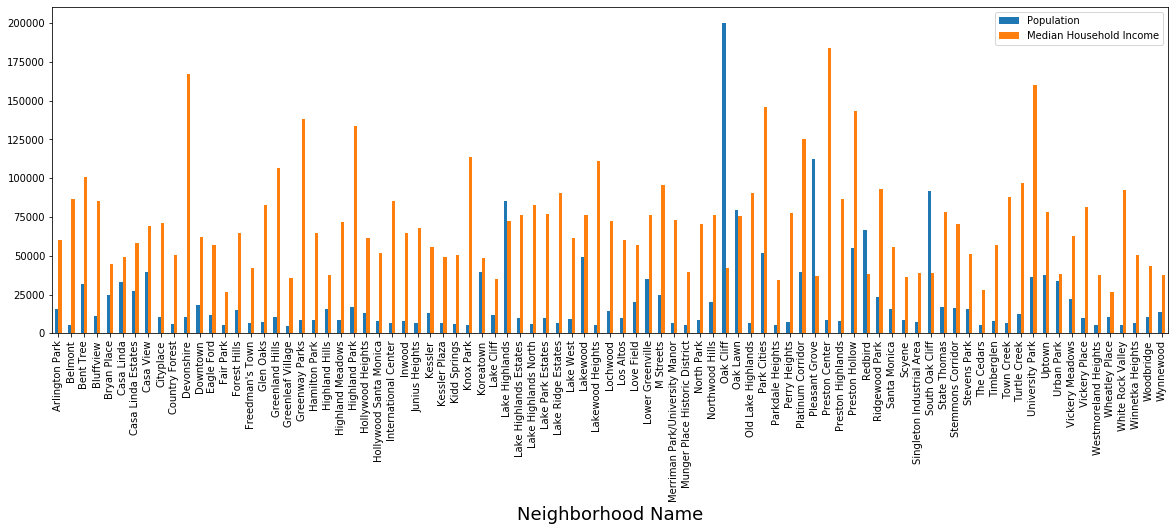

In [10]:
xcount, xbin_edges = np.histogram(texas_df['Median Household Income'],100)
texas_df.plot(kind='bar',figsize=(20, 6))
plt.xticks(np.arange(texas_df.shape[0]), texas_df['Neighborhood Name'])
plt.xlabel('Neighborhood Name', fontsize=18)

plt.show()

Lets create a bar gragh to compare Male and Female average age for each neighborhood.

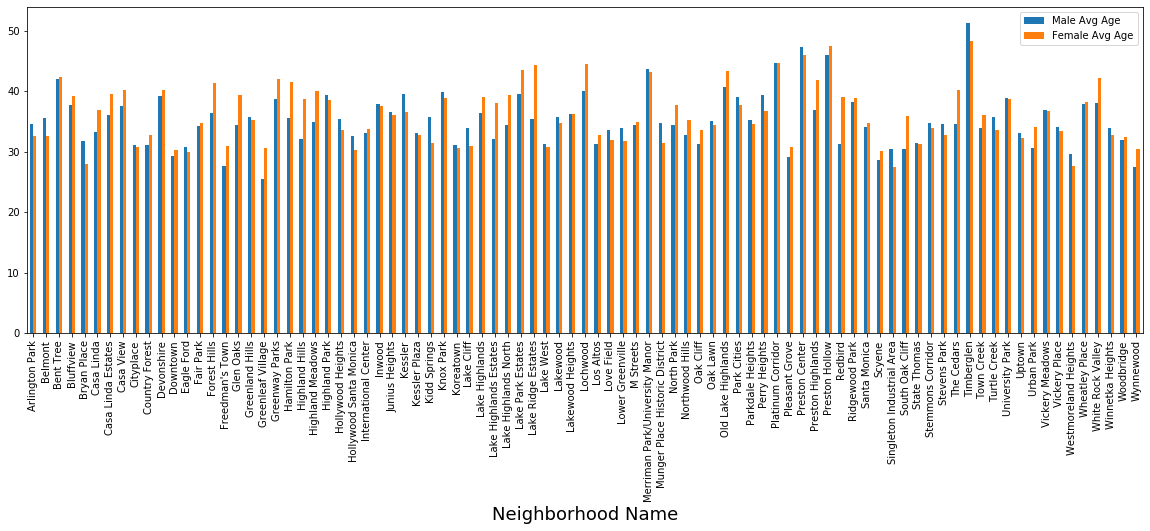

In [11]:
age_table = texas_df[['Male Avg Age','Female Avg Age']].astype(float)
age_table.plot(kind='bar',figsize=(20, 6))
plt.xticks(np.arange(texas_df.shape[0]), texas_df['Neighborhood Name'])
plt.xlabel('Neighborhood Name', fontsize=18)

plt.show()

Let's find out how many neighborhoods are there.

In [12]:
print('The dataframe has {} neighborhoods.'.format(texas_df.shape[0]))

The dataframe has 87 neighborhoods.


Let's find out how many rows and columns are there.

In [13]:
texas_df.shape

(87, 6)

<a id="ref2"></a>
## 2. Load Geographical coordinates of each neighborhood

Now that we have built a dataframe for the neighborhoods of Dallas, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

Let's use geopy library to get the latitude and longitude values of each neighborhood.

In [14]:
latitudes = []
longitudes = []
for city,hood in zip(texas_df['City'],texas_df['Neighborhood Name']):
    geolocator = Nominatim(user_agent="texas_explorer")
    address = hood + ', ' + city
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        latitudes.append(latitude)
        longitude = location.longitude
        longitudes.append(longitude)
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    except:
        latitude = np.nan
        latitudes.append(latitude)
        longitude = np.nan
        longitudes.append(longitude)
        print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

texas_df['Latitude'] = latitudes
texas_df['Longitude'] = longitudes

The geograpical coordinate of Arlington Park, Dallas are 32.81760525, -96.8576092922061.
The geograpical coordinate of Belmont, Dallas are 32.8137335, -96.7822526474138.
The geograpical coordinate of Bent Tree, Dallas are 32.9734109, -96.82630605603083.
The geograpical coordinate of Bluffview, Dallas are 32.9764019, -96.90840146928147.
The geograpical coordinate of Bryan Place, Dallas are 32.60167, -96.952126.
The geograpical coordinate of Casa Linda, Dallas are 34.0514735, -117.2319477.
The geograpical coordinate of Casa Linda Estates, Dallas are nan, nan.
The geograpical coordinate of Casa View, Dallas are 32.7762719, -96.7968559.
The geograpical coordinate of Cityplace, Dallas are 32.7762719, -96.7968559.
The geograpical coordinate of Country Forest, Dallas are 43.3249854, -1.9711967.
The geograpical coordinate of Devonshire, Dallas are 32.855165, -96.9685179.
The geograpical coordinate of Downtown, Dallas are 32.7797876, -96.7980118.
The geograpical coordinate of Eagle Ford, Dallas

Size of the dataframe.

In [15]:
texas_df.shape

(87, 8)

Let's examine the dataframe.

In [16]:
texas_df.head()

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,Latitude,Longitude
0,Dallas,Arlington Park,15390.0,34.6,32.6,59967.0,32.817605,-96.857609
1,Dallas,Belmont,5085.0,35.5,32.6,86718.0,32.813733,-96.782253
2,Dallas,Bent Tree,31951.0,42.0,42.3,100680.0,32.973411,-96.826306
3,Dallas,Bluffview,11335.0,37.7,39.2,85257.0,32.976402,-96.908401
4,Dallas,Bryan Place,24660.0,31.7,28.0,44804.0,32.601670,-96.952126


Let's clean the data after extracting latitude and longitude values.

In [17]:
texas_df = texas_df.dropna(axis=0,how='any').reset_index(drop=True)

texas_df[['Latitude','Longitude']]=texas_df[['Latitude','Longitude']].astype(float).round(3)
texas_df[['Population']]=texas_df[['Population']].astype(int)

texas_df=texas_df.drop_duplicates(subset=['Latitude','Longitude'],keep='first')

Let's check the size of the dataframe.

In [18]:
texas_df.shape

(63, 8)

Let's examine the dataframe again.

In [19]:
texas_df.head()

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,Latitude,Longitude
0,Dallas,Arlington Park,15390,34.6,32.6,59967.0,32.818,-96.858
1,Dallas,Belmont,5085,35.5,32.6,86718.0,32.814,-96.782
2,Dallas,Bent Tree,31951,42.0,42.3,100680.0,32.973,-96.826
3,Dallas,Bluffview,11335,37.7,39.2,85257.0,32.976,-96.908
4,Dallas,Bryan Place,24660,31.7,28.0,44804.0,32.602,-96.952


### Data visualization before clustering

Let's create a map of Texas with neighborhoods of Dallas superimposed on top.

#### Use geopy library to get the latitude and longitude values of Texas.

In [20]:
address = 'Dallas,Texas'

geolocator = Nominatim(user_agent="texas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Texas are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Texas are 32.7762719, -96.7968559.


#### Create a map of Texas with neighborhoods of Dallas superimposed on top.

In [23]:
# create map of Toronto using latitude and longitude values
map_texas = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, cit, hood in zip(texas_df['Latitude'], texas_df['Longitude'], texas_df['City'],texas_df['Neighborhood Name']):
    #print(hood)
    label = folium.Popup(hood+', '+cit, parse_html=True)
    #print(hood.strip())
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_texas)  
    
map_texas

#### Define Foursquare Credentials and Version

In [24]:
# The code was removed by Watson Studio for sharing.

#### Let's create a function to get the top 100 venues that are within a radius of 2000 meters for all neighborhoods in Dallas.

In [25]:
def getNearbyVenues(city_names,names, latitudes, longitudes, radius=2000):
    LIMIT=100
    venues_list=[]

    for city_name,name, lat, lng in zip(city_names,names, latitudes, longitudes):
        print(name.strip())
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                city_name,
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            venues_list.append([(
                city_name,
                name, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *texas_venues*.

In [26]:
texas_venues = getNearbyVenues(city_names=texas_df['City'],
                                   names=texas_df['Neighborhood Name'],
                                   latitudes=texas_df['Latitude'],
                                   longitudes=texas_df['Longitude']
                                  )

Arlington Park
Belmont
Bent Tree
Bluffview
Bryan Place
Casa Linda
Casa View
Country Forest
Devonshire
Downtown
Eagle Ford
Fair Park
Forest Hills
Glen Oaks
Greenleaf Village
Greenway Parks
Hamilton Park
Highland Hills
Highland Meadows
Highland Park
International Center
Inwood
Kessler
Kidd Springs
Knox Park
Lake Cliff
Lake Highlands
Lake West
Lakewood
Lochwood
Los Altos
Love Field
Lower Greenville
North Park
Northwood Hills
Oak Cliff
Oak Lawn
Parkdale Heights
Perry Heights
Pleasant Grove
Preston Center
Preston Highlands
Preston Hollow
Redbird
Ridgewood Park
Santa Monica
Scyene
Singleton Industrial Area
State Thomas
Stevens Park
The Cedars
Timberglen
Town Creek
Turtle Creek
University Park
Uptown
Urban Park
Vickery Meadows
Westmoreland Heights
Wheatley Place
White Rock Valley
Woodbridge
Wynnewood


#### Let's check the size of the resulting dataframe

In [27]:
print(texas_venues.shape)
texas_venues.head()

(4284, 8)


,City,Neighborhood Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dallas,Arlington Park,32.818,-96.858,Sushi Time,32.821937,-96.856740,Sushi Restaurant
1,Dallas,Arlington Park,32.818,-96.858,New Fine Arts Alternatives,32.821748,-96.856172,Bookstore
2,Dallas,Arlington Park,32.818,-96.858,Hampton Inn & Suites,32.811370,-96.858243,Hotel
3,Dallas,Arlington Park,32.818,-96.858,Jimmy John's,32.821892,-96.855460,Sandwich Place
4,Dallas,Arlington Park,32.818,-96.858,Smokey's John's Bar-B-Que,32.821695,-96.854113,BBQ Joint


Let's check how many venues were returned for each neighborhood

In [28]:
texas_venues.groupby('Neighborhood Name').count()

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood Name,,,,,,,
Arlington Park,90,90,90,90,90,90,90
Belmont,100,100,100,100,100,100,100
Bent Tree,89,89,89,89,89,89,89
Bluffview,92,92,92,92,92,92,92
Bryan Place,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Westmoreland Heights,4,4,4,4,4,4,4
Wheatley Place,100,100,100,100,100,100,100
White Rock Valley,79,79,79,79,79,79,79


#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(texas_venues['Venue Category'].unique())))

There are 300 uniques categories.


<a id="ref3"></a>
## 3. Analyze each neighborhood in Dallas

In [30]:
#one hot encoding
texas_onehot = pd.get_dummies(texas_venues[['Venue Category']],prefix='',prefix_sep='').reset_index(drop=True)
texas_onehot.insert(0,'City',texas_venues[['City']])
texas_onehot.insert(1,'Neighborhood Name',texas_venues[['Neighborhood Name']])
texas_onehot.head()

,City,Neighborhood Name,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dallas,Arlington Park,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dallas,Arlington Park,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dallas,Arlington Park,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dallas,Arlington Park,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dallas,Arlington Park,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [31]:
texas_onehot.shape

(4284, 301)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [32]:
texas_grouped = texas_onehot.groupby('Neighborhood Name').mean().reset_index()
texas_grouped.head()

,Neighborhood Name,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Arlington Park,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.077778,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011111,0.00000,0.000000,0.0,0.0
1,Belmont,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.060000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.00000,0.010000,0.0,0.0
2,Bent Tree,0.00000,0.00,0.0,0.011236,0.0,0.0,0.0,0.022472,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011236,0.00000,0.011236,0.0,0.0
3,Bluffview,0.01087,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.01087,0.000000,0.0,0.0
4,Bryan Place,0.00000,0.01,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.01000,0.000000,0.0,0.0


#### Let's confirm the new size

In [33]:
texas_grouped.shape

(62, 300)

Let's join the dataframes texas_df and texas_grouped to form a new dataframe: texas_df_group.

In [34]:
texas_df_group = texas_df
texas_df_group = texas_df_group.join(texas_grouped.set_index('Neighborhood Name'),on='Neighborhood Name')
texas_df_group=texas_df_group.dropna(axis=0,how='any')
print(texas_df_group.shape)
texas_df_group.head()

(62, 307)


,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,Latitude,Longitude,ATM,Accessories Store,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dallas,Arlington Park,15390,34.6,32.6,59967.0,32.818,-96.858,0.00000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.011111,0.00000,0.000000,0.0,0.0
1,Dallas,Belmont,5085,35.5,32.6,86718.0,32.814,-96.782,0.00000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.00000,0.010000,0.0,0.0
2,Dallas,Bent Tree,31951,42.0,42.3,100680.0,32.973,-96.826,0.00000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.011236,0.00000,0.011236,0.0,0.0
3,Dallas,Bluffview,11335,37.7,39.2,85257.0,32.976,-96.908,0.01087,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.01087,0.000000,0.0,0.0
4,Dallas,Bryan Place,24660,31.7,28.0,44804.0,32.602,-96.952,0.00000,0.01,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.01000,0.000000,0.0,0.0


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood Name'] = texas_grouped['Neighborhood Name']

for ind in np.arange(texas_grouped.shape[0]):    
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(texas_grouped.iloc[ind, :], num_top_venues)

print("Size of the dataframe: ",neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

Size of the dataframe:  (62, 11)


,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington Park,Hotel,American Restaurant,Sandwich Place,BBQ Joint,Burger Joint,Mexican Restaurant,Fast Food Restaurant,Rental Car Location,Convenience Store,Gas Station
1,Belmont,American Restaurant,Bar,Pizza Place,Coffee Shop,Mexican Restaurant,Restaurant,Taco Place,Thai Restaurant,New American Restaurant,Grocery Store
2,Bent Tree,Rental Car Location,Pizza Place,Italian Restaurant,Burger Joint,Park,Hotel,Golf Course,Steakhouse,Gas Station,Sushi Restaurant
3,Bluffview,Korean Restaurant,Sushi Restaurant,Sandwich Place,Coffee Shop,Bakery,Fast Food Restaurant,Bubble Tea Shop,Ice Cream Shop,Mexican Restaurant,Pizza Place
4,Bryan Place,Clothing Store,Burger Joint,Cosmetics Shop,Mexican Restaurant,Discount Store,Coffee Shop,Furniture / Home Store,Department Store,Sushi Restaurant,Supplement Shop


Let's look for 'NaN' in any cell of the dataframe and drop the respecive row(s) if any.

In [37]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.dropna(axis=0,how='any')

Let's recheck the size of the dataframe.

In [38]:
neighborhoods_venues_sorted.shape

(62, 11)

<a id="ref4"></a>
## 4. Cluster Neighborhoods in Dallas

### Feature selection

The features such as Population, Median Household income, Male/Female average age and the mean value of neighborhood venues are considered for clustering neighborhoods. Since each feature has different magnitude, let's normalize the data using StandardScaler and use the normalized data to cluster Neighborhoods.

Let's proceed with the feature selection.

In [39]:
texas_grouped_clustering = texas_df_group.drop(['Neighborhood Name','City','Latitude','Longitude'], 1)
texas_grouped_clustering.replace('$419,903',np.nan,inplace=True)
texas_grouped_clustering.replace('$400,055',np.nan,inplace=True)
texas_grouped_clustering.dropna(axis=0,how='any',inplace=True)
texas_grouped_clustering = texas_grouped_clustering.astype(float)
texas_grouped_clustering.head()

,Population,Male Avg Age,Female Avg Age,Median Household Income,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,15390.0,34.6,32.6,59967.0,0.00000,0.00,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011111,0.00000,0.000000,0.0,0.0
1,5085.0,35.5,32.6,86718.0,0.00000,0.00,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.00000,0.010000,0.0,0.0
2,31951.0,42.0,42.3,100680.0,0.00000,0.00,0.0,0.011236,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011236,0.00000,0.011236,0.0,0.0
3,11335.0,37.7,39.2,85257.0,0.01087,0.00,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.01087,0.000000,0.0,0.0
4,24660.0,31.7,28.0,44804.0,0.00000,0.01,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.01000,0.000000,0.0,0.0


### Machine Learning algorithm selection

The **K-means** machine learning algorithm is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from **unlabeled data**.

Some real-world applications of k-means:
- Customer segmentation
- Understand what the visitors of a website are trying to accomplish
- Pattern recognition
- Machine learning
- Data compression

We are going to use k-Means for neighborhood segmentation.

Let's run *k*-means to cluster the neighborhoods into 4 clusters.

In [40]:
# set number of clusters
kclusters = 4

#Normalize the data
texas_grouped_clustering = texas_grouped_clustering.astype(float)
texas_grouped_clustering = StandardScaler().fit(texas_grouped_clustering).transform(texas_grouped_clustering)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(texas_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 0, 3, 0, 2, 2, 0, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [41]:
# add clustering labels
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

texas_merged = texas_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
texas_merged = texas_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood Name'), on='Neighborhood Name')

print("Size of the dataframe after adding Cluster Label",texas_merged.shape)
texas_merged.head() # check the last columns!

Size of the dataframe after adding Cluster Label (63, 19)


,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dallas,Arlington Park,15390,34.6,32.6,59967.0,32.818,-96.858,3.0,Hotel,American Restaurant,Sandwich Place,BBQ Joint,Burger Joint,Mexican Restaurant,Fast Food Restaurant,Rental Car Location,Convenience Store,Gas Station
1,Dallas,Belmont,5085,35.5,32.6,86718.0,32.814,-96.782,0.0,American Restaurant,Bar,Pizza Place,Coffee Shop,Mexican Restaurant,Restaurant,Taco Place,Thai Restaurant,New American Restaurant,Grocery Store
2,Dallas,Bent Tree,31951,42.0,42.3,100680.0,32.973,-96.826,0.0,Rental Car Location,Pizza Place,Italian Restaurant,Burger Joint,Park,Hotel,Golf Course,Steakhouse,Gas Station,Sushi Restaurant
3,Dallas,Bluffview,11335,37.7,39.2,85257.0,32.976,-96.908,0.0,Korean Restaurant,Sushi Restaurant,Sandwich Place,Coffee Shop,Bakery,Fast Food Restaurant,Bubble Tea Shop,Ice Cream Shop,Mexican Restaurant,Pizza Place
4,Dallas,Bryan Place,24660,31.7,28.0,44804.0,32.602,-96.952,3.0,Clothing Store,Burger Joint,Cosmetics Shop,Mexican Restaurant,Discount Store,Coffee Shop,Furniture / Home Store,Department Store,Sushi Restaurant,Supplement Shop


Let's look for NaN values in any of the cells in the dataframe and drop them if any.

In [42]:
texas_merged = texas_merged.dropna(axis=0,how='any')

Size of the dataframe after cleanup.

In [43]:
texas_merged.shape

(62, 19)

### Data visualization

Finally, let's visualize the resulting clusters.

In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
#colors_array = plt.cm.Spectral(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)

# add markers to the map
markers_colors = []
for ind,lat, lon, poi, cluster,city_name in zip(texas_merged.index,texas_merged['Latitude'], texas_merged['Longitude'], texas_merged['Neighborhood Name'], texas_merged['Cluster Labels'],texas_merged['City']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + 'Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id="ref5"></a>
## 5. Examine the clusters and Identify the best cluster to start a Tutoring Center in Dallas

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### Cluster 1 - Neighborhood type : Ethnic

In [45]:
texas_merged.loc[texas_merged['Cluster Labels'] == 0, texas_merged.columns[list(range(0,6))+ list(range(9, texas_merged.shape[1]))]].sort_values(by='Population',ascending=False).reset_index(drop=True).head(10)

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dallas,Oak Cliff,200297,31.3,33.5,41991.0,Mexican Restaurant,Zoo Exhibit,Restaurant,Fried Chicken Joint,Brewery,Taco Place,Italian Restaurant,Gastropub,Convenience Store,Pizza Place
1,Dallas,Oak Lawn,79350,35.1,34.4,75484.0,Gay Bar,Bar,Mexican Restaurant,Seafood Restaurant,Coffee Shop,Hotel,Nail Salon,Italian Restaurant,Salon / Barbershop,Burger Joint
2,Dallas,Preston Hollow,54703,45.9,47.4,143411.0,Bakery,Italian Restaurant,Pizza Place,Ice Cream Shop,Shipping Store,Seafood Restaurant,Sandwich Place,Mexican Restaurant,Spa,Café
3,Dallas,Lakewood,49005,35.8,34.8,76122.0,Mexican Restaurant,Cosmetics Shop,Burger Joint,Bar,Discount Store,Pizza Place,Coffee Shop,Sushi Restaurant,Pet Store,Park
4,Dallas,Uptown,37818,33.0,32.3,78443.0,American Restaurant,Cocktail Bar,Hotel,Sushi Restaurant,Japanese Restaurant,Burger Joint,Coffee Shop,Seafood Restaurant,Steakhouse,Mexican Restaurant
5,Dallas,University Park,35995,38.8,38.7,160096.0,Bakery,Coffee Shop,American Restaurant,Seafood Restaurant,Ice Cream Shop,Mediterranean Restaurant,New American Restaurant,Cupcake Shop,Sandwich Place,Gym / Fitness Center
6,Dallas,Lower Greenville,34956,33.9,31.8,76117.0,Mexican Restaurant,Bar,Pizza Place,New American Restaurant,Grocery Store,Coffee Shop,Thai Restaurant,Burger Joint,Taco Place,Vietnamese Restaurant
7,Dallas,Casa Linda,33127,33.2,36.9,48949.0,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,Pizza Place,Thai Restaurant,Sandwich Place,Ice Cream Shop,Mobile Phone Shop,Dessert Shop
8,Dallas,Bent Tree,31951,42.0,42.3,100680.0,Rental Car Location,Pizza Place,Italian Restaurant,Burger Joint,Park,Hotel,Golf Course,Steakhouse,Gas Station,Sushi Restaurant
9,Dallas,Vickery Meadows,22311,36.9,36.7,63062.0,Mexican Restaurant,Department Store,Fast Food Restaurant,Cosmetics Shop,Sandwich Place,Coffee Shop,American Restaurant,Sporting Goods Shop,Bank,Taco Place


### Cluster 2 - Neighborhood type : Urban Pioneer

In [46]:
#texas_merged.loc[texas_merged['Cluster Labels'] == 1, texas_merged.columns[list(range(0,6))+ list(range(9, texas_merged.shape[1]))]].sort_values(['Population'],ascending=False).reset_index(drop=True).head(10)
texas_merged.loc[texas_merged['Cluster Labels'] == 1].sort_values(['Population'],ascending=False).reset_index(drop=True).head(10)

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dallas,Singleton Industrial Area,7240,30.4,27.5,38608.0,32.779,-96.826,1.0,Italian Restaurant,Brewery,Event Space,Taco Place,Plaza,Mexican Restaurant,Scenic Lookout,Hotel,Asian Restaurant,Pizza Place


### Cluster 3 - Neighborhood type : Urban Core (Downtown)

In [47]:
texas_merged.loc[texas_merged['Cluster Labels'] == 2, texas_merged.columns[list(range(0,6))+ list(range(9, texas_merged.shape[1]))]].sort_values(by='Population',ascending=False).reset_index(drop=True).head(10)

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dallas,Casa View,39253,37.6,40.2,69417.0,Hotel,Coffee Shop,Steakhouse,Plaza,Bar,Cocktail Bar,American Restaurant,Park,History Museum,Café
1,Dallas,Downtown,18395,29.2,30.2,61939.0,Hotel,Coffee Shop,Park,Cocktail Bar,American Restaurant,Mexican Restaurant,Steakhouse,Plaza,Gym,Movie Theater
2,Dallas,Wheatley Place,10619,37.8,38.2,26649.0,American Restaurant,Burger Joint,Steakhouse,Japanese Restaurant,Seafood Restaurant,Mexican Restaurant,Cocktail Bar,Coffee Shop,Hotel,New American Restaurant
3,Dallas,Greenway Parks,8275,38.7,42.0,137987.0,Pizza Place,Discount Store,Coffee Shop,Fast Food Restaurant,New American Restaurant,Bar,American Restaurant,Sandwich Place,Hotel,Brewery
4,Dallas,International Center,6772,33.0,33.7,85388.0,Hotel,American Restaurant,Bar,Coffee Shop,Steakhouse,Cocktail Bar,New American Restaurant,Seafood Restaurant,Japanese Restaurant,Mexican Restaurant
5,Dallas,Country Forest,6180,31.1,32.8,50420.0,Tapas Restaurant,Coffee Shop,Restaurant,Hotel,Bar,Nightclub,Spanish Restaurant,Plaza,Scenic Lookout,Café
6,Dallas,Fair Park,5291,34.3,34.7,26811.0,Bar,American Restaurant,Dive Bar,Burger Joint,Coffee Shop,Cocktail Bar,Art Gallery,Pizza Place,Rock Club,Nightclub
7,Dallas,The Cedars,5068,34.6,40.2,27760.0,Hotel,Coffee Shop,Cocktail Bar,Bar,American Restaurant,Park,History Museum,Burger Joint,Brewery,BBQ Joint


### Cluster 4 - Neighborhood type : Cul-de-sacs & Kids (Bedroom)

In [48]:
texas_merged.loc[texas_merged['Cluster Labels'] == 3, texas_merged.columns[list(range(0,6))+ list(range(9, texas_merged.shape[1]))]].sort_values(by='Population',ascending=False).reset_index(drop=True).head(10)

,City,Neighborhood Name,Population,Male Avg Age,Female Avg Age,Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dallas,Pleasant Grove,112549,29.1,30.7,36852.0,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Convenience Store,Fried Chicken Joint,Thrift / Vintage Store,Grocery Store,Discount Store,Burger Joint,Gas Station
1,Dallas,Lake Highlands,85169,36.3,39.0,72459.0,Pizza Place,Fast Food Restaurant,Sandwich Place,Convenience Store,Pharmacy,Coffee Shop,Mexican Restaurant,Grocery Store,Bank,Video Store
2,Dallas,Redbird,66535,31.3,39.1,37968.0,Fast Food Restaurant,Discount Store,Convenience Store,Pizza Place,Fried Chicken Joint,Department Store,Wings Joint,Southern / Soul Food Restaurant,Sandwich Place,Big Box Store
3,Dallas,Urban Park,33552,30.6,34.0,38557.0,Fried Chicken Joint,Breakfast Spot,Pharmacy,Discount Store,Chinese Restaurant,Convenience Store,Fast Food Restaurant,Home Service,Gas Station,Mexican Restaurant
4,Dallas,Bryan Place,24660,31.7,28.0,44804.0,Clothing Store,Burger Joint,Cosmetics Shop,Mexican Restaurant,Discount Store,Coffee Shop,Furniture / Home Store,Department Store,Sushi Restaurant,Supplement Shop
5,Dallas,Ridgewood Park,23467,38.2,38.9,92875.0,Fast Food Restaurant,Breakfast Spot,Hardware Store,Sandwich Place,Bank,Liquor Store,Gas Station,Supplement Shop,Garden Center,Big Box Store
6,Dallas,Love Field,20048,33.6,32.0,57009.0,Rental Car Location,Mexican Restaurant,Airport Service,Coffee Shop,Fast Food Restaurant,Convenience Store,Hotel,Sandwich Place,Burger Joint,Shoe Store
7,Dallas,Northwood Hills,20015,32.8,35.3,76500.0,ATM,Athletics & Sports,Playground,Pharmacy,Chinese Restaurant,Salon / Barbershop,Breakfast Spot,Soccer Field,Spa,Speakeasy
8,Dallas,State Thomas,16715,31.5,31.2,78486.0,Food,Zoo Exhibit,Fish & Chips Shop,Event Space,Eye Doctor,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Flea Market
9,Dallas,Highland Hills,15895,32.1,38.7,37515.0,Gas Station,Convenience Store,Mobile Phone Shop,Grocery Store,Truck Stop,Discount Store,Fast Food Restaurant,Seafood Restaurant,Spa,Hotel


### Data visualization

Let's visualize the cluster to make sure we have selected the correct neighborhood to start the tutoring center in Dallas.

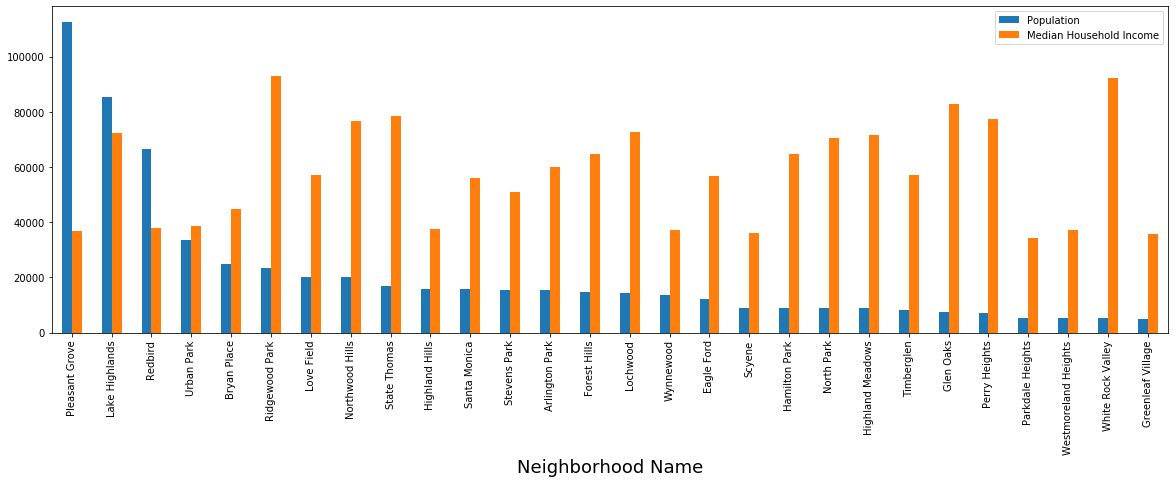

In [53]:
ncluster = 3
final_table = texas_merged[texas_merged['Cluster Labels'] == ncluster].sort_values('Population',ascending=False).reset_index(drop=True)
final_table = final_table[['Neighborhood Name','Population','Median Household Income']].reset_index(drop=True)
final_table.plot(kind='bar',figsize=(20, 6))
plt.xticks(np.arange(final_table.shape[0]), final_table['Neighborhood Name'])
plt.xlabel('Neighborhood Name', fontsize=18)

plt.show()

<a id="ref6"></a>
## 6. Conclusion

Based on the data analysis (per the combination of the features such as *Population, Median Household Income, Male/Female average age and Venues list*) and KMeans machine learning algorithm's clusters(neighborhood types), we can conclude that **Lake Highlands** is the perfect neighborhood to start the first tutoring center in Dallas.

### Thank you!

This notebook was created by Janaranjani Kannan.